# BD. Lab 8. Recommender Systems

In [1]:
import numpy as np
import scipy
import pandas as pd
import random
import sklearn


from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Loading data

In [2]:
articles_df = pd.read_csv('../input/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df = articles_df[articles_df['lang'] == 'en']
del articles_df['lang']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...


In [3]:
interactions_df = pd.read_csv('../input/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [4]:
5/(interactions_df.groupby('eventType', as_index=False).size()/interactions_df.shape[0]*5+1)

eventType
BOOKMARK           4.272395
COMMENT CREATED    4.498861
FOLLOW             4.556694
LIKE               3.578491
VIEW               0.957161
dtype: float64

In [5]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 3.6, 
   'BOOKMARK': 4.3, 
   'FOLLOW': 4.6,
   'COMMENT CREATED': 4.5,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [6]:
interactions_df

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,4.6
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...
72307,1485190425,LIKE,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR,3.6
72308,1485190425,VIEW,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
72309,1485190072,VIEW,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR,1.0
72310,1485190434,VIEW,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR,1.0


In [7]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


In [8]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


In [9]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(lambda x: np.log10(x+1)*2).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,0.602060
1,-9223121837663643404,-8377626164558006982,0.602060
2,-9223121837663643404,-8208801367848627943,0.602060
3,-9223121837663643404,-8187220755213888616,0.602060
4,-9223121837663643404,-7423191370472335463,1.908485
5,-9223121837663643404,-7331393944609614247,0.602060
6,-9223121837663643404,-6872546942144599345,0.602060
7,-9223121837663643404,-6728844082024523434,0.602060
8,-9223121837663643404,-6590819806697898649,0.602060
9,-9223121837663643404,-6558712014192834002,0.954243


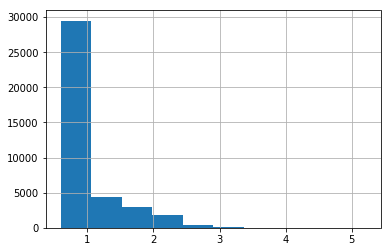

In [10]:
interactions_full_df['eventStrength'].hist()

In [11]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, stratify=interactions_full_df['personId'], 
                                                               test_size=0.2, random_state=666)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


In [12]:
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [13]:
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [14]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=666):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
        
    def _apk(self, actual, predicted, k=10):
        if len(predicted)>k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not actual:
            return 0.0

        return score / min(len(actual), k)

    def evaluate_model_for_user(self, model, person_id):
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        for item_id in person_interacted_items_testset:
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        
        apk_at_5 = self._apk(person_interacted_items_testset, valid_recs, 5)
        apk_at_10 = self._apk(person_interacted_items_testset, valid_recs, 10)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'apk@5': apk_at_5,
                          'apk@10': apk_at_10}
        return person_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            try:
                person_metrics = self.evaluate_model_for_user(model, person_id)  
                person_metrics['_person_id'] = person_id
                people_metrics.append(person_metrics)
            except:
                pass
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics)
        print(detailed_results_df.columns)
        detailed_results_df = detailed_results_df.sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'mapk@5': detailed_results_df['apk@5'].mean(),
                          'mapk@10': detailed_results_df['apk@10'].mean()
                         }    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [15]:
interactions_test_indexed_df.index.unique().values.shape

(1140,)

# Popularity model

In [16]:
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,200.847396
1,-6783772548752091658,150.559034
2,-133139342397538859,144.792954
3,-8208801367848627943,126.986008
4,-6843047699859121724,125.197923
5,8224860111193157980,125.037284
6,-2358756719610361882,118.331942
7,2581138407738454418,115.699690
8,7507067965574797372,111.885506
9,1469580151036142903,108.938323


In [17]:
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...


In [18]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df):
        self.popularity_df = popularity_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False).head(topn)

        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df)

In [19]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed
Index(['hits@5_count', 'hits@10_count', 'interacted_count', 'recall@5',
       'recall@10', 'apk@5', 'apk@10', '_person_id'],
      dtype='object')

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.28266428023523393, 'recall@10': 0.41089235489644593, 'mapk@5': 0.057706384015594483, 'mapk@10': 0.0566740358667833}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,apk@5,apk@10,_person_id
9,33,58,192,0.171875,0.302083,0.0,0.0,3609194402293569455
13,15,32,134,0.111940,0.238806,0.0,0.0,-2626634673110551643
14,13,23,130,0.100000,0.176923,0.0,0.0,-1032019229384696495
107,8,19,117,0.068376,0.162393,0.0,0.0,-1443636648652872475
36,25,38,88,0.284091,0.431818,0.0,0.0,-2979881261169775358
3,9,12,80,0.112500,0.150000,0.0,0.0,-3596626804281480007
15,16,30,73,0.219178,0.410959,0.0,0.0,1116121227607581999
130,15,20,69,0.217391,0.289855,0.0,0.0,692689608292948411
206,14,25,69,0.202899,0.362319,0.0,0.0,-9016528795238256703
6,19,34,68,0.279412,0.500000,0.0,0.0,3636910968448833585


# Content-Based Filtering model

In [20]:
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords.words('english'))

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + " " + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<2211x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 559886 stored elements in Compressed Sparse Row format>

In [21]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    try:
        item_profiles_list = [get_item_profile(x) for x in ids]
    except:
        item_profiles_list = [get_item_profile(x) for x in [ids]]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [22]:
interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId').index.unique()

Int64Index([-1443636648652872475,  1722265956540512475, -2901997243166418276,
             3829784524040647339,  4254153380739593270, -4298177694576275482,
            -3230911339419872436, -6944500707172804068,  -108842214936804958,
            -8853658195208337106,
            ...
            -3381527457560577265,  1761626329244869141,  3937943558206985686,
              -57558373945119606, -1272364595235252747, -2644571257397324782,
             3948719927571797789,  6500990175526024713, -4744441833918341987,
            -4082616567756603262],
           dtype='int64', name='personId', length=1109)

In [23]:
user_profiles = build_users_profiles()
len(user_profiles)

1109

In [24]:
user_profiles[-1443636648652872475]

array([[0.00164965, 0.02725625, 0.00140874, ..., 0.00271118, 0.00329048,
        0.00034598]])

In [25]:
profile = user_profiles[6500990175526024713]
print(profile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[6500990175526024713].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,languages,0.411518
1,rankings,0.300415
2,scala,0.270009
3,2014,0.248456
4,ranking,0.239281
5,data,0.206452
6,python,0.197400
7,language,0.179303
8,big data,0.165669
9,spectrum,0.160253


In [26]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']).head(topn)

        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [27]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed
Index(['hits@5_count', 'hits@10_count', 'interacted_count', 'recall@5',
       'recall@10', 'apk@5', 'apk@10', '_person_id'],
      dtype='object')

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.12257484260567904, 'recall@10': 0.18489014518823077, 'mapk@5': 0.018207343953511677, 'mapk@10': 0.018643578553219367}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,apk@5,apk@10,_person_id
9,11,19,192,0.057292,0.098958,0.00,0.000,3609194402293569455
13,8,13,134,0.059701,0.097015,0.00,0.000,-2626634673110551643
14,11,18,130,0.084615,0.138462,0.00,0.000,-1032019229384696495
105,28,42,117,0.239316,0.358974,0.00,0.010,-1443636648652872475
35,10,18,88,0.113636,0.204545,0.00,0.000,-2979881261169775358
3,13,21,80,0.162500,0.262500,0.00,0.000,-3596626804281480007
15,8,16,73,0.109589,0.219178,0.00,0.000,1116121227607581999
204,6,12,69,0.086957,0.173913,0.00,0.000,-9016528795238256703
128,10,13,69,0.144928,0.188406,0.05,0.025,692689608292948411
6,2,5,68,0.029412,0.073529,0.00,0.000,3636910968448833585


## Collaborative Filtering model

## Matrix Factorization

In [28]:
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,1.496376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.49637605, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [30]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [31]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2909 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [32]:
NUMBER_OF_FACTORS_MF = 30

U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [33]:
U.shape

(1140, 30)

In [34]:
Vt.shape

(30, 2909)

In [35]:
sigma = np.diag(sigma)
sigma.shape

(30, 30)

In [36]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
np.round(all_user_predicted_ratings, 3)

array([[ 0.013,  0.002,  0.014, ..., -0.005,  0.018,  0.006],
       [ 0.006,  0.   , -0.   , ..., -0.   ,  0.003,  0.   ],
       [ 0.015,  0.016, -0.035, ..., -0.003,  0.007,  0.01 ],
       ...,
       [-0.008, -0.001, -0.023, ..., -0.016,  0.029,  0.002],
       [-0.002,  0.008,  0.016, ...,  0.002,  0.017, -0.003],
       [-0.002,  0.003,  0.15 , ..., -0.02 ,  0.021,  0.007]])

In [37]:
np.max(np.round(all_user_predicted_ratings, 3) - np.round(users_items_pivot_matrix, 3))

1.821

In [38]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [39]:
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.219672,0.218411,0.220107,0.217680,0.216844,0.216450,0.216798,0.220427,0.221905,0.218917,...,0.215217,0.213267,0.217324,0.219700,0.220426,0.217442,0.216554,0.215859,0.216986,0.216938
-9216926795620865886,0.217675,0.217413,0.220400,0.217527,0.217388,0.217362,0.217346,0.217662,0.216868,0.217749,...,0.217338,0.220417,0.217321,0.217492,0.218048,0.217383,0.217718,0.217154,0.218785,0.217830
-9194572880052200111,0.219868,0.217295,0.210861,0.218213,0.222424,0.216128,0.221978,0.214965,0.211342,0.223519,...,0.218561,0.224294,0.218047,0.220249,0.234716,0.222497,0.216720,0.213086,0.220233,0.245331
-9192549002213406534,0.219595,0.217950,0.219471,0.215725,0.216078,0.219151,0.219588,0.222528,0.215641,0.208673,...,0.219001,0.231969,0.219298,0.217700,0.217551,0.218794,0.215440,0.218378,0.215635,0.225573
-9190737901804729417,0.220811,0.216689,0.218813,0.219129,0.217061,0.217305,0.217948,0.216816,0.218363,0.218690,...,0.218818,0.218524,0.217163,0.216961,0.218537,0.217117,0.216878,0.218079,0.217983,0.214266
-9189659052158407108,0.218890,0.218275,0.214719,0.217572,0.218414,0.217553,0.219279,0.217596,0.221460,0.219656,...,0.220667,0.225996,0.217711,0.217573,0.222158,0.219853,0.217633,0.221724,0.218120,0.224162
-9184137057748005562,0.217370,0.217365,0.217411,0.217168,0.217338,0.217332,0.217192,0.217291,0.217433,0.217887,...,0.217352,0.218336,0.217332,0.217337,0.217611,0.217316,0.217472,0.217433,0.217680,0.216818
-9176143510534135851,0.219878,0.218552,0.218352,0.217697,0.216562,0.216280,0.218486,0.219534,0.214243,0.225189,...,0.217963,0.232760,0.216512,0.215783,0.217102,0.217194,0.216452,0.218885,0.219723,0.232032
-9171475473795142532,0.220072,0.217452,0.219509,0.218305,0.217020,0.217384,0.219923,0.216200,0.213669,0.219423,...,0.216904,0.220164,0.216956,0.216770,0.212545,0.216769,0.217206,0.218552,0.218442,0.217141


In [40]:
len(cf_preds_df.columns)

1140

In [41]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler, StandardScaler

nmf_model = NMF(20)

vals = nmf_model.fit_transform(users_items_pivot_sparse_matrix)

nmf_result = np.dot(vals, nmf_model.components_)

nmf_result = (nmf_result - nmf_result.min()) / (nmf_result.max() - nmf_result.min())

cf_preds_df = pd.DataFrame(nmf_result, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.007857,0.000431,0.001796,1.323930e-03,0.000000,0.000000,0.001313,0.001109,0.000024,0.008341,...,0.001510,0.005851,0.000627,0.001378,0.000620,0.000000e+00,0.000667,0.000000,0.003491,0.000903
-9216926795620865886,0.000126,0.000014,0.000829,7.522454e-05,0.000002,0.000003,0.000081,0.000014,0.000013,0.000342,...,0.000050,0.000224,0.000000,0.000405,0.002108,0.000000e+00,0.000111,0.000100,0.000201,0.000001
-9194572880052200111,0.002770,0.000000,0.004681,4.726609e-04,0.002654,0.000000,0.003532,0.000000,0.002895,0.004718,...,0.000717,0.012885,0.000181,0.002264,0.018011,2.254923e-03,0.000659,0.001140,0.006392,0.018349
-9192549002213406534,0.008350,0.000468,0.000119,3.476393e-04,0.003803,0.001297,0.001577,0.003064,0.007914,0.001206,...,0.000600,0.021527,0.001700,0.002411,0.010646,4.985181e-03,0.000652,0.002285,0.003123,0.029977
-9190737901804729417,0.003555,0.000000,0.000559,8.771878e-04,0.000000,0.000000,0.000021,0.000000,0.000000,0.000243,...,0.001879,0.000030,0.000000,0.000000,0.000000,0.000000e+00,0.000002,0.000014,0.000012,0.000000
-9189659052158407108,0.002811,0.001225,0.000917,1.538597e-04,0.001582,0.000265,0.001053,0.000711,0.002912,0.001283,...,0.002311,0.008730,0.000174,0.000249,0.009661,1.828999e-03,0.000612,0.001223,0.002060,0.011458
-9184137057748005562,0.000184,0.000002,0.000023,4.634227e-05,0.000000,0.000012,0.000087,0.000000,0.000064,0.000584,...,0.000109,0.000209,0.000015,0.000032,0.000048,0.000000e+00,0.000036,0.000040,0.000156,0.000070
-9176143510534135851,0.004858,0.000760,0.000205,1.247597e-03,0.000000,0.000085,0.001935,0.002793,0.016923,0.010807,...,0.002392,0.012042,0.000000,0.000059,0.008281,1.463865e-05,0.001190,0.010705,0.003515,0.005938
-9171475473795142532,0.004972,0.000001,0.001495,1.007044e-03,0.000000,0.000147,0.003842,0.000070,0.000005,0.003939,...,0.000672,0.005522,0.000193,0.000242,0.000088,5.015284e-07,0.000460,0.002576,0.002132,0.000161


In [42]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler, StandardScaler

nmf_model = LatentDirichletAllocation(20)

vals = nmf_model.fit_transform(users_items_pivot_sparse_matrix)

nmf_result = np.dot(vals, nmf_model.components_)

nmf_result = (nmf_result - nmf_result.min()) / (nmf_result.max() - nmf_result.min())

cf_preds_df = pd.DataFrame(nmf_result, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.022509,0.001579,0.000725,0.003061,0.001304,0.001091,0.000462,0.011112,0.000255,0.010243,...,0.000636,0.015048,0.000795,0.000873,0.000148,0.001275,0.000650,0.000670,0.015362,0.021570
-9216926795620865886,0.000207,0.001223,0.098581,0.000730,0.001009,0.000845,0.102455,0.000502,0.000198,0.000192,...,0.000492,0.000090,0.000616,0.000676,0.000115,0.000987,0.000503,0.000519,0.000487,0.000111
-9194572880052200111,0.002347,0.011353,0.001243,0.001617,0.089854,0.001871,0.000792,0.001112,0.047872,0.000427,...,0.001090,0.043751,0.001364,0.001497,0.019217,0.090027,0.001115,0.001150,0.001080,0.054394
-9192549002213406534,0.035657,0.074357,0.002496,0.008201,0.004491,0.003756,0.001590,0.026715,0.026114,0.000858,...,0.022634,0.023571,0.002737,0.011380,0.036432,0.028174,0.002239,0.011989,0.002168,0.020700
-9190737901804729417,0.000093,0.000550,0.000252,0.009744,0.000454,0.000380,0.000161,0.000226,0.000089,0.000086,...,0.009701,0.000040,0.000277,0.004187,0.000051,0.000444,0.000226,0.000233,0.000219,0.000050
-9189659052158407108,0.004425,0.020948,0.001439,0.001871,0.002587,0.033507,0.000916,0.001286,0.054639,0.002750,...,0.001261,0.052262,0.001578,0.001732,0.027323,0.053552,0.028589,0.007586,0.016233,0.000286
-9184137057748005562,0.000019,0.000116,0.000053,0.000069,0.000096,0.000080,0.000033,0.000047,0.000018,0.001644,...,0.000046,0.000008,0.000058,0.005310,0.000010,0.000094,0.000047,0.000049,0.000046,0.000010
-9176143510534135851,0.034901,0.003246,0.001490,0.038748,0.002680,0.021076,0.000949,0.031212,0.046181,0.049511,...,0.001307,0.036469,0.001635,0.013263,0.000305,0.002621,0.016209,0.001378,0.044661,0.000296
-9171475473795142532,0.000118,0.000698,0.000320,0.010383,0.000576,0.023249,0.000204,0.000286,0.000113,0.000110,...,0.000281,0.001744,0.000351,0.000386,0.001173,0.000564,0.018265,0.000296,0.011162,0.000063


In [43]:
interactions = pd.melt(interactions_train_df.pivot(index='personId', columns='contentId', values='eventStrength').fillna(0).reset_index(), 
        id_vars=['personId'])

interactions

,personId,contentId,value
0,-9223121837663643404,-9222795471790223670,0.0
1,-9212075797126931087,-9222795471790223670,0.0
2,-9207251133131336884,-9222795471790223670,0.0
3,-9199575329909162940,-9222795471790223670,0.0
4,-9196668942822132778,-9222795471790223670,0.0
...,...,...,...
3316255,9165571805999894845,9222265156747237864,0.0
3316256,9187866633451383747,9222265156747237864,0.0
3316257,9191849144618614467,9222265156747237864,0.0
3316258,9199170757466086545,9222265156747237864,0.0


In [44]:
X = interactions.merge(articles_df, on='contentId', how='left').select_dtypes(include=['float', 'int']).fillna(0).drop(columns=['value'])

y = interactions.merge(articles_df, on='contentId', how='left')['value'].fillna(0).values.reshape((-1,1))

from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin.fit(X, y)

lin.predict(X)

array([[0.0112682 ],
       [0.01126782],
       [0.01126766],
       ...,
       [0.0076656 ],
       [0.00766536],
       [0.00766497]])

In [45]:
y.reshape(1,-1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [46]:
pd.DataFrame({'real': lin.predict(X).reshape(1,-1)[0], 'pred': y.reshape(1,-1)[0]})

,real,pred
0,0.011268,0.0
1,0.011268,0.0
2,0.011268,0.0
3,0.011267,0.0
4,0.011267,0.0
...,...,...
3316255,0.007666,0.0
3316256,0.007666,0.0
3316257,0.007666,0.0
3316258,0.007665,0.0


In [47]:
interactions['pred'] = lin.predict(X).reshape(1,-1)[0]

cf_preds_df = interactions.pivot(index='personId', columns='contentId', values='pred').fillna(0)
cf_preds_df

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.011268,0.011268,0.011268,0.008306,0.008337,0.008322,0.011268,0.011268,0.008222,0.008389,...,0.011268,0.008359,0.008323,0.008311,0.011268,0.011268,0.008306,0.008322,0.008076,0.008286
-9212075797126931087,0.011268,0.011268,0.011268,0.008305,0.008337,0.008321,0.011268,0.011268,0.008222,0.008389,...,0.011268,0.008359,0.008322,0.008311,0.011268,0.011268,0.008305,0.008321,0.008076,0.008286
-9207251133131336884,0.011268,0.011268,0.011268,0.008305,0.008337,0.008321,0.011268,0.011268,0.008222,0.008389,...,0.011268,0.008358,0.008322,0.008311,0.011268,0.011268,0.008305,0.008321,0.008075,0.008286
-9199575329909162940,0.011267,0.011267,0.011267,0.008305,0.008337,0.008321,0.011267,0.011267,0.008221,0.008388,...,0.011267,0.008358,0.008322,0.008311,0.011267,0.011267,0.008305,0.008321,0.008075,0.008285
-9196668942822132778,0.011267,0.011267,0.011267,0.008305,0.008336,0.008321,0.011267,0.011267,0.008221,0.008388,...,0.011267,0.008358,0.008322,0.008310,0.011267,0.011267,0.008305,0.008321,0.008075,0.008285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9165571805999894845,0.010648,0.010648,0.010648,0.007686,0.007718,0.007702,0.010648,0.010648,0.007602,0.007769,...,0.010648,0.007739,0.007703,0.007692,0.010648,0.010648,0.007686,0.007702,0.007456,0.007666
9187866633451383747,0.010648,0.010648,0.010648,0.007685,0.007717,0.007701,0.010648,0.010648,0.007602,0.007769,...,0.010648,0.007738,0.007702,0.007691,0.010648,0.010648,0.007685,0.007701,0.007455,0.007666
9191849144618614467,0.010648,0.010648,0.010648,0.007685,0.007717,0.007701,0.010648,0.010648,0.007602,0.007769,...,0.010648,0.007738,0.007702,0.007691,0.010648,0.010648,0.007685,0.007701,0.007455,0.007666


In [48]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [49]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed
Index([], dtype='object')


KeyError: 'interacted_count'

## Association rules

In [50]:
dataset = list(interactions_df.groupby('personId', as_index=False).agg({'contentId': list})['contentId'].values)

In [51]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

from mlxtend.frequent_patterns import fpgrowth, association_rules

res = association_rules(fpgrowth(df, min_support=0.005, use_colnames=True, max_len=2), metric="lift", min_threshold=1).sort_values('lift', ascending=False)

res['antecedents'] = [list(i)[0] for i in res['antecedents']]
res['consequents'] = [list(i)[0] for i in res['consequents']]

res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17260,-6504694273023533189,4068119742428755460,0.007388,0.007388,0.005277,0.714286,96.683673,0.005222,3.474142
17261,4068119742428755460,-6504694273023533189,0.007388,0.007388,0.005277,0.714286,96.683673,0.005222,3.474142
13424,-788035419968530567,6941466664989793964,0.008971,0.009499,0.007388,0.823529,86.699346,0.007303,5.612841
13425,6941466664989793964,-788035419968530567,0.009499,0.008971,0.007388,0.777778,86.699346,0.007303,4.459631
16882,5439554346835640135,2032007496318616962,0.007388,0.008443,0.005277,0.714286,84.598214,0.005215,3.470449
...,...,...,...,...,...,...,...,...,...
2568,-4029704725707465084,5658521282502533116,0.141425,0.040633,0.006860,0.048507,1.193788,0.001114,1.008276
16,-6783772548752091658,1469580151036142903,0.101847,0.074934,0.008971,0.088083,1.175473,0.001339,1.014419
17,1469580151036142903,-6783772548752091658,0.074934,0.101847,0.008971,0.119718,1.175473,0.001339,1.020302
1656,-6156751702010469220,-4029704725707465084,0.051715,0.141425,0.008443,0.163265,1.154432,0.001129,1.026102


In [52]:
#interactions_df

In [53]:
class AprioriRecommender:
    
    MODEL_NAME = 'Apriori'
    
    def __init__(self, rules_df=None):
        self.rules_df = rules_df
        #self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=10):
        cands = list(interactions_df.loc[interactions_df['personId'] == person_id, 'contentId'].values)
        
        cands = interactions_df.loc[interactions_df['personId'] == person_id, ['contentId', 'eventStrength']]
        
        cands = cands.merge(self.rules_df, right_on='antecedents', left_on='contentId', how='left')
        
        cands['lift'] = np.log(cands['lift'] * cands['eventStrength'])
        
        selected_cands = cands.loc[:, ['consequents', 'lift']].sort_values('lift', ascending=False)

        return selected_cands
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        similar_items_filtered = similar_items.loc[~similar_items['consequents'].isin(items_to_ignore),:]
        similar_items_filtered.columns=['contentId', 'recStrength']
        recommendations_df = similar_items_filtered.head(topn)
        return recommendations_df
    
apriori_recommender_model = AprioriRecommender(res)

In [54]:
print('Evaluating Apriori model...')
ap_global_metrics, ap_detailed_results_df = model_evaluator.evaluate_model(apriori_recommender_model)
print('\nGlobal metrics:\n%s' % ap_global_metrics)
ap_detailed_results_df.head(10)

Evaluating Apriori model...
1139 users processed
Index(['hits@5_count', 'hits@10_count', 'interacted_count', 'recall@5',
       'recall@10', 'apk@5', 'apk@10', '_person_id'],
      dtype='object')

Global metrics:
{'modelName': 'Apriori', 'recall@5': 0.28394272564561496, 'recall@10': 0.36614676553311176, 'mapk@5': 0.03846734892787525, 'mapk@10': 0.040187621832358675}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,apk@5,apk@10,_person_id
9,27,43,192,0.140625,0.223958,0.0,0.0,3609194402293569455
13,28,31,134,0.208955,0.231343,0.0,0.0,-2626634673110551643
14,14,16,130,0.107692,0.123077,0.0,0.0,-1032019229384696495
107,15,18,117,0.128205,0.153846,0.0,0.0,-1443636648652872475
36,24,33,88,0.272727,0.375000,0.0,0.0,-2979881261169775358
3,8,9,80,0.100000,0.112500,0.0,0.0,-3596626804281480007
15,25,30,73,0.342466,0.410959,0.0,0.0,1116121227607581999
130,8,15,69,0.115942,0.217391,0.0,0.0,692689608292948411
206,11,14,69,0.159420,0.202899,0.0,0.0,-9016528795238256703
6,16,25,68,0.235294,0.367647,0.0,0.0,3636910968448833585


## Hybrid Recommender

In [55]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, ap_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0, ap_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.ap_rec_model = ap_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.ap_ensemble_weight = ap_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})        
        ap_recs_df = self.ap_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, 
                                                        topn=100).rename(columns={'recStrength': 'recStrengthAP'})
        
        recs_df = cb_recs_df.merge(cf_recs_df, how = 'outer', left_on = 'contentId', right_on = 'contentId').fillna(0.0) \
                            .merge(ap_recs_df, how = 'outer', left_on = 'contentId', right_on = 'contentId').fillna(0.0)
        
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) + (recs_df['recStrengthCF'] * self.cf_ensemble_weight) + (recs_df['recStrengthAP'] * self.ap_ensemble_weight)
        
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)
        
        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, apriori_recommender_model, articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0, ap_ensemble_weight=1.0)

In [56]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed
Index([], dtype='object')


KeyError: 'interacted_count'

## Comparing the methods

In [57]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics, 
                                  ap_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

NameError: name 'cf_global_metrics' is not defined

In [58]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

NameError: name 'global_metrics_df' is not defined

# Testing

In [59]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 'contentId', 'title', 'url']]

In [60]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url
96,2.795880,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...
56,2.571115,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...
42,2.491025,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...
88,2.445433,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...
69,2.429688,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...
27,2.375041,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...
53,2.334635,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...
86,2.234543,-5658245291907121574,Machine Learning and the VP Debate,https://medium.com/@srobtweets/machine-learnin...
33,2.200741,444378495316508239,How to choose algorithms for Microsoft Azure M...,https://azure.microsoft.com/en-us/documentatio...
99,2.165571,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...
